In [1]:
import tensorflow as tf
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import re
import time
import math


path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [3]:
text = re.sub('\.', ' <eos>', text)
text = re.sub('\!', ' <eos>', text)
text = re.sub('\?', ' <eos>', text)
text = re.sub('\,', '', text)
text = re.sub('\:', ' :', text)
text = re.sub('\;', '', text)
text = re.sub('\--', ' <eos>', text)

In [4]:
text = ' '.join(text.split())

In [ ]:
text

In [ ]:
text_lower = []
for i in text.split():
  i = i.lower()
  text_lower.append(i)
  
text_lower = ' '.join(text_lower)
text_lower

In [ ]:
word_counts = {}

for i in range(len(text_lower.split())):
  if text_lower.split()[i] in word_counts:
    word_counts[text_lower.split()[i]] += 1
  else:
    word_counts[text_lower.split()[i]] = 1

In [8]:
word_counts_list = []
for key in word_counts:
  word_counts_list.append((key, word_counts[key]))

In [ ]:
ordered_list = sorted(word_counts_list, key = lambda word: word[1], reverse=True)
print(len(ordered_list))
ordered_list = ordered_list[0:5000]
ordered_list

In [10]:
word2idx = {}
for i in range(len(ordered_list)):
  word2idx[ordered_list[i][0]] = i
print(len(word2idx))
word2idx['<unk>'] = len(word2idx)
print(len(word2idx))

5000
5001


In [11]:
text_words = []
text_idx = []

for word in text_lower.split():
    words = []
    idx = []
    if word in word2idx:
      text_words.append(word)
      text_idx.append(word2idx[word])
    else:
      words.append('<unk>')
      idx.append(len(word2idx)-1)

text_words = ' '.join(text_words)

In [32]:
#creates sequences of a certain length

seq_length = 32

text_words_seq = []
text_idx_seq = []

for i in range(len(text_words.split()) - seq_length):
  seq_wds = ' '.join(text_words.split()[i : i + seq_length])
  text_words_seq.append(seq_wds)

  seq_idxs = text_idx[i : i + seq_length]
  text_idx_seq.append(seq_idxs)

KeyboardInterrupt: ignored

In [62]:
#text_idx_seq = [t.numpy() for t in text_idx_seq]
#data = torch.tensor(text_idx_seq)

# 80 percent train, 10 percent validation, 10 percent test split

end1 = round(len(text_words_seq)*.8) # to get 90% for training
end2 = round(len(text_words_seq)*.9) # to get 5% for validation and test
print(end1)
print(end2)

train_data = torch.Tensor(data[0:end1])
val_data = torch.Tensor(data[end1:end2])
test_data = torch.Tensor(data[end2:])

127386
143310


In [14]:
class twoLayer_LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, layers):
        super().__init__()
        self.emb_layer = nn.Embedding(vocab_size, hidden_size)
        self.rec_layer = nn.LSTM(hidden_size, hidden_size, num_layers=layers)
        self.lin_layer = nn.Linear(hidden_size, vocab_size)
        # if want to make bi directional
        #self.rec_layer = nn.LSTM(hidden_size, hidden_size, num_layers=layers, bidirectional=True)
        #self.lin_layer = nn.Linear(hidden_size*2, vocab_size)

    def forward(self, word_seq, h_init, c_init):
        g_seq = self.emb_layer(word_seq)  
        h_seq, (h_last, c_last) = self.rec_layer(g_seq, (h_init, c_init))
        score_seq = self.lin_layer(h_seq)
        return score_seq, (h_last, c_last)

In [65]:
def evaluate(data):
    running_loss = 0
    num_batches = 0    
    with torch.no_grad():
        h = torch.zeros(layers, bs, hidden_size)
        c = torch.zeros(layers, bs, hidden_size)
        h = h.to(device)
        c = c.to(device)
        for count in range(0, len(data) - bs, bs):
            minibatch_data = data.long()[count:count + bs]
            minibatch_label = data.long()[count+1:count + bs + 1]
            minibatch_data = minibatch_data.to(device)
            minibatch_label = minibatch_label.to(device)
            scores, (h, c) = net(minibatch_data, h, c)
            minibatch_label = minibatch_label.view(bs * seq_length) 
            scores = scores.view(bs * seq_length, vocab_size)
            loss = criterion(scores, minibatch_label)    
            h = h.detach()
            c = c.detach()
            num_batches += 1  
    return loss.item()

def normalize_gradient(net):
    grad_norm_sq = 0
    for p in net.parameters():
        grad_norm_sq += p.grad.data.norm()**2
    grad_norm = math.sqrt(grad_norm_sq)
    if grad_norm < 1e-4:
        net.zero_grad()
        print('grad norm close to zero')
    else:    
        for p in net.parameters():
             p.grad.data.div_(grad_norm)
    return grad_norm

In [88]:
# setup NN
hidden_size = 100
vocab_size = len(word2idx)+1
layers = 2
num_epoch = 8
bs = 32

device = torch.device("cuda")
net = twoLayer_LSTM(vocab_size, hidden_size, layers)
net.emb_layer.weight.data.uniform_(-0.1, 0.1)
net.lin_layer.weight = net.emb_layer.weight
net = net.to(device)
criterion = nn.CrossEntropyLoss()
train_size = len(train_data)

In [87]:
# training with SGD
start = time.time()

train_loss_list = []
val_loss_list = []
test_loss_list = []

for epoch in range(num_epoch):
    #if epoch > 0:
    my_lr = 1.5 * math.exp(-0.5 * epoch)
    optimizer = optim.SGD(net.parameters(), lr=my_lr, momentum=0.9)
            
    # set the running quantities to zero at the beginning of the epoch
    running_loss = 0
    num_batches = 0    
       
    # set the initial h to be the zero vector
    h = torch.zeros(layers, bs, hidden_size)
    c = torch.zeros(layers, bs, hidden_size)
    # send it to the gpu    
    h = h.to(device)
    c = c.to(device)

    for count in range(0, train_size - bs, bs):    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch
        minibatch_data = train_data.long()[count : count + bs]
        minibatch_label = train_data.long()[count + 1 : count + bs + 1]
                
        # send them to the gpu
        minibatch_data = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)
        
        # Detach to prevent from backpropagating all the way to the beginning
        # Then tell Pytorch to start tracking all operations that will be done on h and c
        h = h.detach()
        c = c.detach()
        h = h.requires_grad_()
        c = c.requires_grad_()
        # forward the minibatch through the net 
        scores, (h, c) = net(minibatch_data, h, c)
        # reshape the scores and labels to huge batch of size bs*seq_length
        scores = scores.view(bs * seq_length, vocab_size)  
        minibatch_label = minibatch_label.view(bs * seq_length)       
        
        # Compute the average of the losses of the data points in this huge batch
        loss = criterion(scores, minibatch_label)
        
        # backward pass to compute dL/dR, dL/dV and dL/dW
        loss.backward()

        # do one step of stochastic gradient descent: R=R-lr(dL/dR), V=V-lr(dL/dV), ...
        normalize_gradient(net)
        optimizer.step()
        
        # update the running loss  
        #running_loss += loss.item()
        num_batches += 1
                          
    #total_loss = running_loss/num_batches
    elapsed = time.time() - start
    print('\nepoch =', epoch, '\t time = {0:.1f}'.format(elapsed),'\t lr = {0:.3f}'.format(my_lr), '\t training loss = {0:.3f}'.format(loss.item())) # compute error on the test set at end of each epoch
    val_loss = evaluate(val_data) # eval on the validation set
    train_loss_list.append(loss.item())
    val_loss_list.append(val_loss)
    test_loss = evaluate(test_data) # eval on the test set
    test_loss_list.append(test_loss)
    print('val loss = {0:.3f}'.format(val_loss))
    print('test loss = {0:.3f}'.format(test_loss))

print(" ")


epoch = 0 	 time = 84.9 	 lr = 1.500 	 training loss = 6.019
val loss = 6.670
test loss = 6.551

epoch = 1 	 time = 172.5 	 lr = 0.910 	 training loss = 5.510
val loss = 6.292
test loss = 5.964

epoch = 2 	 time = 259.9 	 lr = 0.552 	 training loss = 5.163
val loss = 6.089
test loss = 5.833

epoch = 3 	 time = 346.3 	 lr = 0.335 	 training loss = 4.980
val loss = 5.969
test loss = 5.608

epoch = 4 	 time = 431.9 	 lr = 0.203 	 training loss = 4.876
val loss = 5.787
test loss = 5.368

epoch = 5 	 time = 518.2 	 lr = 0.123 	 training loss = 4.801
val loss = 5.668
test loss = 5.304

epoch = 6 	 time = 605.2 	 lr = 0.075 	 training loss = 4.735
val loss = 5.605
test loss = 5.278

epoch = 7 	 time = 692.9 	 lr = 0.045 	 training loss = 4.684
val loss = 5.544
test loss = 5.282
 


In [91]:
# training with Adagrad
start = time.time()

train_loss_list = []
val_loss_list = []
test_loss_list = []

for epoch in range(num_epoch):
    #if epoch > 0:
    my_lr = 0.1 * math.exp(-0.5 * epoch)
    optimizer = optim.Adagrad(net.parameters(), lr=my_lr)
            
    # set the running quantities to zero at the beginning of the epoch
    running_loss = 0
    num_batches = 0    
       
    # set the initial h to be the zero vector
    h = torch.zeros(layers, bs, hidden_size)
    c = torch.zeros(layers, bs, hidden_size)
    # send it to the gpu    
    h = h.to(device)
    c = c.to(device)

    for count in range(0, train_size - bs, bs):    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch
        minibatch_data = train_data.long()[count : count + bs]
        minibatch_label = train_data.long()[count + 1 : count + bs + 1]        
                
        # send them to the gpu
        minibatch_data = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)
        
        # Detach to prevent from backpropagating all the way to the beginning
        # Then tell Pytorch to start tracking all operations that will be done on h and c
        h = h.detach()
        c = c.detach()
        h = h.requires_grad_()
        c = c.requires_grad_()
        # forward the minibatch through the net 
        scores, (h, c) = net(minibatch_data, h, c)
        # reshape the scores and labels to huge batch of size bs*seq_length
        scores = scores.view(bs * seq_length, vocab_size)  
        minibatch_label = minibatch_label.view(bs * seq_length)       
        
        # Compute the average of the losses of the data points in this huge batch
        loss = criterion(scores, minibatch_label)
        
        # backward pass to compute dL/dR, dL/dV and dL/dW
        loss.backward()

        # do one step of stochastic gradient descent: R=R-lr(dL/dR), V=V-lr(dL/dV), ...
        normalize_gradient(net)
        optimizer.step()
        
        # update the running loss  
        #running_loss += loss.item()
        num_batches += 1
                          
    #total_loss = running_loss/num_batches
    elapsed = time.time() - start
    print('\nepoch =', epoch, '\t time = {0:.1f}'.format(elapsed),'\t lr = {0:.3f}'.format(my_lr), '\t training loss = {0:.3f}'.format(loss.item())) # compute error on the test set at end of each epoch
    val_loss = evaluate(val_data) # eval on the validation set
    train_loss_list.append(loss.item())
    val_loss_list.append(val_loss)
    test_loss = evaluate(test_data) # eval on the test set
    test_loss_list.append(test_loss)
    print('val loss = {0:.3f}'.format(val_loss))
    print('test loss = {0:.3f}'.format(test_loss))

print(" ")


epoch = 0 	 time = 84.2 	 lr = 0.100 	 training loss = 4.541
val loss = 5.423
test loss = 5.368

epoch = 1 	 time = 169.9 	 lr = 0.061 	 training loss = 4.569
val loss = 5.524
test loss = 5.411

epoch = 2 	 time = 254.4 	 lr = 0.037 	 training loss = 4.453
val loss = 5.427
test loss = 5.368

epoch = 3 	 time = 338.4 	 lr = 0.022 	 training loss = 4.485
val loss = 5.482
test loss = 5.462

epoch = 4 	 time = 422.5 	 lr = 0.014 	 training loss = 4.469
val loss = 5.476
test loss = 5.495

epoch = 5 	 time = 506.2 	 lr = 0.008 	 training loss = 4.473
val loss = 5.533
test loss = 5.527

epoch = 6 	 time = 590.4 	 lr = 0.005 	 training loss = 4.464
val loss = 5.539
test loss = 5.503

epoch = 7 	 time = 675.8 	 lr = 0.003 	 training loss = 4.480
val loss = 5.525
test loss = 5.469
 


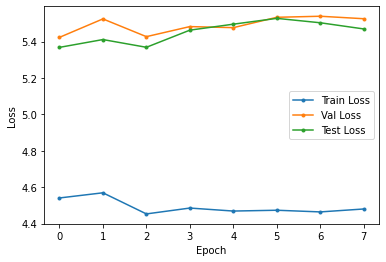

In [92]:
x = range(0, num_epoch,1)

plt.plot(x, train_loss_list, '.-', label='Train Loss')
plt.plot(x, val_loss_list, '.-', label='Val Loss')
plt.plot(x, test_loss_list, '.-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [70]:
idx2word = {y:x for x, y in word2idx.items()}

In [71]:
def show_most_likely_words(prob):
    num_word_display = 15
    p = prob.view(-1)
    p, word_idx = torch.topk(p, num_word_display)
    for i, idx in enumerate(word_idx):
        percentage = p[i].item() * 100
        word = idx2word[idx.item()]
        print("{:.1f}%\t".format(percentage), word) 

def text2tensor(text):
    text = text.lower()
    list_of_words = text.split()
    list_of_idx = []
    for w in list_of_words:
      if w in word2idx:
        idx = word2idx[w]
        list_of_idx.append(idx)
      else:
        list_of_idx.append(len(word2idx)-1)
    x = torch.LongTensor(list_of_idx)
    return x

In [110]:
sentence = "thou shalt more pikes <eos> menenius : i have not to the people <eos> lady : no no <eos>"

h = torch.zeros(layers, bs, hidden_size)
c = torch.zeros(layers, bs, hidden_size)
h = h.to(device)
c = c.to(device)

data = text2tensor(sentence)
seq_len = len(data)
data = data.view(seq_len, -1)
empty = torch.zeros(seq_len, bs - 1).type(torch.LongTensor)
data = torch.cat((data, empty), dim=1)
data = data.to(device)
scores, (h, c) = net(data, h, c)
scores = scores[seq_len - 1, 0, :]
p = F.softmax(scores.view(1, vocab_size), dim=1)
print(sentence, '... \n')
show_most_likely_words(p)

thou shalt more pikes <eos> menenius : i have not to the people <eos> lady : no no <eos> ... 

20.9%	 gloucester
4.6%	 queen
3.6%	 why
3.4%	 king
2.5%	 clarence
2.0%	 hastings
1.8%	 i
1.7%	 what
1.7%	 lady
1.5%	 edward
1.2%	 messenger
1.2%	 rivers
1.1%	 richard
1.0%	 third
1.0%	 and
